### 1. Problem Statement

- Create a model for predict whether person is survived or not.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,PowerTransformer,LabelEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from mixed_naive_bayes import MixedNB
from sklearn.metrics import classification_report,confusion_matrix
import pickle

### 2. Data Collection

In [2]:
data = sns.load_dataset('titanic')

In [3]:
df = data.copy()

In [4]:
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### 3. EDA Before Pre-processing

In [5]:
df.shape

(891, 15)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [7]:
df.duplicated().sum() 

107

In [8]:
df.drop_duplicates(keep= "first", inplace= True)

In [9]:
df.duplicated().sum() 

0

In [10]:
df.columns

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

In [11]:
df = df[['survived','sex', 'age', 'fare','class','embark_town', 'alone']]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     784 non-null    int64   
 1   sex          784 non-null    object  
 2   age          678 non-null    float64 
 3   fare         784 non-null    float64 
 4   class        784 non-null    category
 5   embark_town  782 non-null    object  
 6   alone        784 non-null    bool    
dtypes: bool(1), category(1), float64(2), int64(1), object(2)
memory usage: 38.4+ KB


In [13]:
df = df.astype(dtype = {'class':'category','alone':'object'})

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     784 non-null    int64   
 1   sex          784 non-null    object  
 2   age          678 non-null    float64 
 3   fare         784 non-null    float64 
 4   class        784 non-null    category
 5   embark_town  782 non-null    object  
 6   alone        784 non-null    object  
dtypes: category(1), float64(2), int64(1), object(3)
memory usage: 43.8+ KB


In [15]:
df['survived'].value_counts()

0    461
1    323
Name: survived, dtype: int64

In [16]:
df['embark_town'].unique()

array(['Southampton', 'Cherbourg', 'Queenstown', nan], dtype=object)

In [17]:
df['class'].unique()

['Third', 'First', 'Second']
Categories (3, object): ['First', 'Second', 'Third']

In [18]:
df['alone'].unique()

array([False, True], dtype=object)

In [19]:
df.describe()

,survived,age,fare
count,784.000000,678.000000,784.000000
mean,0.411990,29.869351,34.711740
std,0.492507,14.759076,52.160151
min,0.000000,0.420000,0.000000
25%,0.000000,20.000000,8.050000
50%,0.000000,28.250000,15.900000
75%,1.000000,39.000000,34.109350
max,1.000000,80.000000,512.329200


In [20]:
feature_var = df[['sex', 'age', 'fare', 'class', 'embark_town', 'alone']]

In [21]:
feature_var.head()

,sex,age,fare,class,embark_town,alone
0,male,22.0,7.2500,Third,Southampton,False
1,female,38.0,71.2833,First,Cherbourg,False
2,female,26.0,7.9250,Third,Southampton,True
3,female,35.0,53.1000,First,Southampton,False
4,male,35.0,8.0500,Third,Southampton,True


In [22]:
class_var = df['survived']

In [23]:
class_var.head()

0    0
1    1
2    1
3    1
4    0
Name: survived, dtype: int64

In [24]:
df["survived"] = df["survived"].map({0:"Un survived", 1:"Survived"})

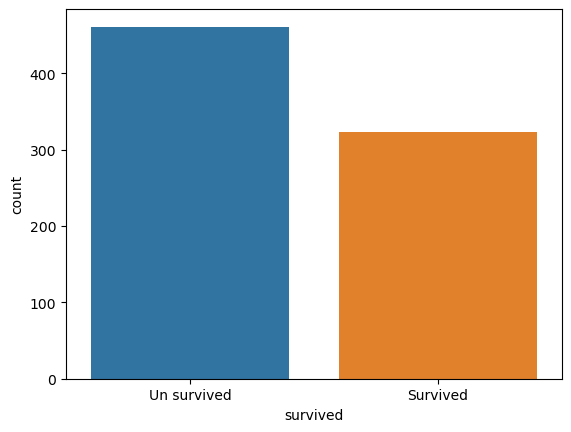

In [25]:
sns.countplot(data= df, x= 'survived')
plt.show()

### 4. Pre-processing

In [26]:
x_train,x_test,y_train,y_test = train_test_split(feature_var, class_var, test_size= 0.2, random_state= 1, stratify= class_var)

In [27]:
x_train.head()

,sex,age,fare,class,embark_town,alone
155,male,51.0,61.3792,First,Cherbourg,False
768,male,NaN,24.1500,Third,Queenstown,False
345,female,24.0,13.0000,Second,Southampton,True
679,male,36.0,512.3292,First,Cherbourg,False
185,male,NaN,50.0000,First,Southampton,True


### 5. EDA After Pre-Processing

In [28]:
x_train.corr(numeric_only= True)

,age,fare
age,1.000000,0.053703
fare,0.053703,1.000000


<Axes: >

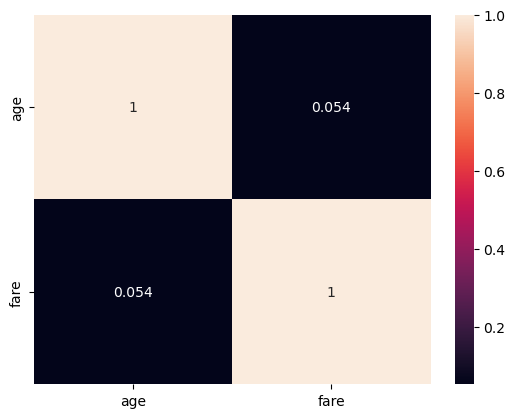

In [29]:
sns.heatmap(x_train.corr(numeric_only= True), annot= True)

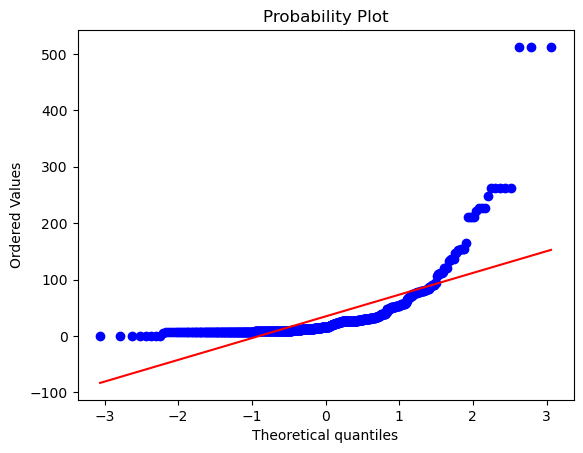

In [30]:
ss.probplot(x_train["fare"],dist = "norm",fit = True,plot = plt)   # x_train["size"] = observed data , norm = theoritical data
plt.show()

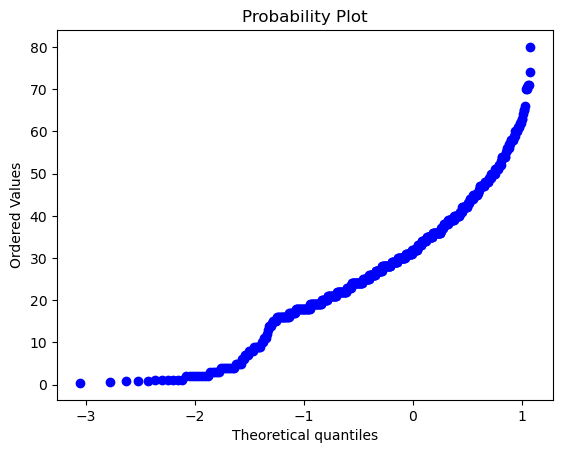

In [31]:
ss.probplot(x_train["age"],dist = "norm",fit = True,plot = plt)   # x_train["size"] = observed data , norm = theoritical data
plt.show()

### 6. Feature Engineering

In [32]:
numerical_data = x_train.select_dtypes(include= ['int64','float64'])

In [33]:
ordinal_data = x_train.select_dtypes(include= ['category'])

In [34]:
nominal_data = x_train.select_dtypes(include= ['object'])

In [35]:
numerical_pipe = Pipeline([('Null_values_imputation_1', SimpleImputer(strategy='mean')),
                           ('StandardScalar', StandardScaler()),
                           ('Power_Transform',PowerTransformer())])

In [36]:
nominal_pipe = Pipeline([('Null_values_imputation_2', SimpleImputer(strategy='most_frequent')),
                         ('OH_Encoding', OneHotEncoder(sparse_output= False, drop= 'first'))])

In [37]:
ordinal_pipe = Pipeline([('Null_values_imputation_2', SimpleImputer(strategy='most_frequent')),
                         ('Ordinal_Encoding', OrdinalEncoder(categories= [['First', 'Second', 'Third']]))])

In [38]:
prepro_col_trans = ColumnTransformer(transformers= [('Ordinal_Pre-Processing', ordinal_pipe, ordinal_data.columns),
                                                    ('Nominal_Pre-Processing', nominal_pipe, nominal_data.columns),
                                                    ('numerical_Pre-Processing', numerical_pipe, numerical_data.columns)],
                                     remainder="passthrough")

In [39]:
feature_extraction_pipe = Pipeline([('Pre-Processing',prepro_col_trans)])

In [40]:
final_x_train = feature_extraction_pipe.fit_transform(x_train)

final_x_test = feature_extraction_pipe.transform(x_test)

In [41]:
feature_extraction_pipe.get_feature_names_out()

array(['Ordinal_Pre-Processing__class',
       'Nominal_Pre-Processing__sex_male',
       'Nominal_Pre-Processing__embark_town_Queenstown',
       'Nominal_Pre-Processing__embark_town_Southampton',
       'Nominal_Pre-Processing__alone_True',
       'numerical_Pre-Processing__age', 'numerical_Pre-Processing__fare'],
      dtype=object)

In [42]:
pickle.dump(feature_extraction_pipe, open(r"C:\Users\pavan\Machine Learning\Projects\Project-4(Titanic)\Titanic_feature_extraction.pkl",'wb'))

### 7. Training & Model Evalution

In [43]:
mixed_nb = MixedNB(categorical_features= [0,1,2,3,4])
model = mixed_nb.fit(final_x_train, y_train)

In [44]:
print(classification_report(y_test, model.predict(final_x_test)))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79        92
           1       0.70      0.71      0.70        65

    accuracy                           0.75       157
   macro avg       0.74      0.75      0.74       157
weighted avg       0.75      0.75      0.75       157



### 8. Testing

In [45]:
res = model.predict(final_x_test[[0]])
if res == 0:
  print("Un servived")
else:
  print("Survived")

Un servived


### 9. Deploying

In [46]:
pickle.dump(model, open(r"C:\Users\pavan\Machine Learning\Projects\Project-4(Titanic)\Titanic_model.pkl",'wb'))

### 10.Conclusion

In conclusion, the development of machine learning models for predicting passenger survival outcomes Through meticulous data preprocessing, feature selection, and model optimization, researchers have been able to construct highly accurate classifiers capable of discerning survival probabilities with remarkable precision. Identification of key predictors, shedding light on the underlying factors that contribute to survival in emergency situations. Features such as age, gender, ticket class, and familial relationships have emerged as influential variables, offering valuable insights into the dynamics of human behavior and decision-making during crises.